# 1912년 타이타닉 사고의 생존자를 예측하기 
## [데이터 설명]
- scikit-learn 내장 데이터
- 891명의 승객에 대한 데이터. 생존여부 / 좌석 등급 / 성별 / 나이 / 일행 / 자녀 / 운임 등의 feature 

In [3]:
# warning 무시
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
# '-' 깨짐 해결 모듈
import matplotlib as mpl

plt.rcParams["font.family"] = "Malgun Gothic"  # For Windows
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8,4)
print(plt.rcParams["font.family"])

# 마이너스 깨짐 해결
mpl.rcParams["axes.unicode_minus"] = False

['Malgun Gothic']


## 라이브러리 임포트

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 데이터 불러오기

In [10]:
# sns 내장 데이터 로딩
titanic_df = sns.load_dataset('titanic')

In [11]:
titanic_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## 탐색적 데이터 분석 수행 

In [12]:
titanic_df.info()
# 결측치 및 dtype 확인 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


#### 범주형 컬럼과 수치형 컬럼으로 나누기 
범주형 컬럼과, 수치형 컬럼으로 나누어서 리스트를 만듬.(추후 분석 시 반복되는 코드를 줄일 수 있음 )   
- 범주형(categorical) 데이터는 값이 [1, 2, 3], ["내부", "외부"]와 같이 몇 가지 분류로 한정되는 데이터임.
- 수치형(numerical) 데이터는 값이 1,2,3,5,..., 1.2, 4.51, 3.1415와 같이 숫자 축으로 무한히 위치할 수 있는 데이터임.

In [17]:
# 범주형 데이터 coiumn 이름만 추출 
categorical_cols = titanic_df.select_dtypes(exclude=np.number).columns.tolist()
# categorical_cols = titanic_df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
print(categorical_cils)

['sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']


In [28]:
# 범주형 데이터 Feature로만 구성된 Dataframe 만들기(중복 컬럼 제외)
categorical_cols = ['sex', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']             
titanic_df[categorical_cols]         

,sex,class,who,adult_male,deck,embark_town,alive,alone
0,male,Third,man,True,NaN,Southampton,no,False
1,female,First,woman,False,C,Cherbourg,yes,False
2,female,Third,woman,False,NaN,Southampton,yes,True
3,female,First,woman,False,C,Southampton,yes,False
4,male,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...
886,male,Second,man,True,NaN,Southampton,no,True
887,female,First,woman,False,B,Southampton,yes,True
888,female,Third,woman,False,NaN,Southampton,no,False
889,male,First,man,True,C,Cherbourg,yes,True


In [19]:
# 수치형 데이터 컬럼 이름 추출 
numerical_cols = titanic_df.select_dtypes(include=np.number).columns.tolist()
print(numerical_cols)

['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']


In [21]:
# 일정 데이터로만 구성된 Dataframe 만들기
numerical_cols2 = ['age', 'sibsp', 'parch', 'fare']
titanic_df[numerical_cols2]

,age,sibsp,parch,fare
0,22.0,1,0,7.2500
1,38.0,1,0,71.2833
2,26.0,0,0,7.9250
3,35.0,1,0,53.1000
4,35.0,0,0,8.0500
...,...,...,...,...
886,27.0,0,0,13.0000
887,19.0,0,0,30.0000
888,NaN,1,2,23.4500
889,26.0,0,0,30.0000


In [22]:
# age 컬럼 type을 int로 변경 시도함
titanic_df['age'] = titanic_df['age'].astype(int)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [23]:
# age 컬럼의 null 값 확인, 데이터의 사실 분석을 위해 null 값은 그대로 유지
titanic_df['age'].isnull().value_counts()

age
False    714
True     177
Name: count, dtype: int64

### 데이터 통계량 살펴보기 
.describe() 함수로 각 열에 대한 대략적인 통계 값들을 볼 수 있음.
(평균, 상위 25/50/75% 값, 최대/최소 값 등)

In [25]:
titanic_df[numerical_cols2].describe()

,age,sibsp,parch,fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [26]:
titanic_df['who'].value_counts()

who
man      537
woman    271
child     83
Name: count, dtype: int64

#### [문제해결] 범주형 데이터들의 value count를 계산하는 반복문 구현하기 
- .value_counts()를 통해 각 컬럼별로 몇 개의 row가 있는지 셀 수 있음.
- value count 결과를 내림차순으로 소팅해서 출력하기

In [35]:
titanic_df['who'].value_counts(ascending=False)

who
man      537
woman    271
child     83
Name: count, dtype: int64

In [43]:
# 범주형 데이터 컬럼들의 value count를 계산하는 반복문 구현하기
for col in categorical_cols :
    print("카운트 :: ")
    print(titanic_df[col].value_counts(ascending=False))
    print("--"*20)
    

카운트 :: 
sex
male      577
female    314
Name: count, dtype: int64
----------------------------------------
카운트 :: 
class
Third     491
First     216
Second    184
Name: count, dtype: int64
----------------------------------------
카운트 :: 
who
man      537
woman    271
child     83
Name: count, dtype: int64
----------------------------------------
카운트 :: 
adult_male
True     537
False    354
Name: count, dtype: int64
----------------------------------------
카운트 :: 
deck
C    59
B    47
D    33
E    32
A    15
F    13
G     4
Name: count, dtype: int64
----------------------------------------
카운트 :: 
embark_town
Southampton    644
Cherbourg      168
Queenstown      77
Name: count, dtype: int64
----------------------------------------
카운트 :: 
alive
no     549
yes    342
Name: count, dtype: int64
----------------------------------------
카운트 :: 
alone
True     537
False    354
Name: count, dtype: int64
----------------------------------------


### 시각화 
#### 수치형 데이터를 boxplot으로 차트화

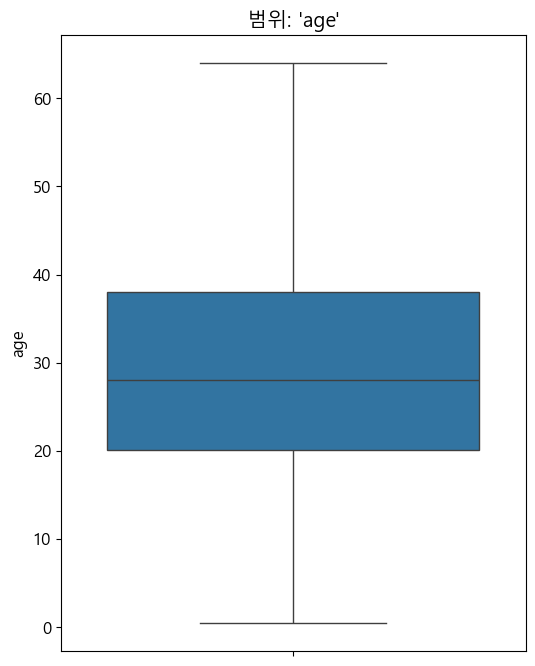

In [67]:
plt.figure(figsize=(6,8)) # 인치
ax = sns.boxplot(data=titanic_df, y='age', showfliers=False)
ax.set_title("범위: 'age'")
plt.show()

In [69]:
numerical_cols2

['age', 'sibsp', 'parch', 'fare']

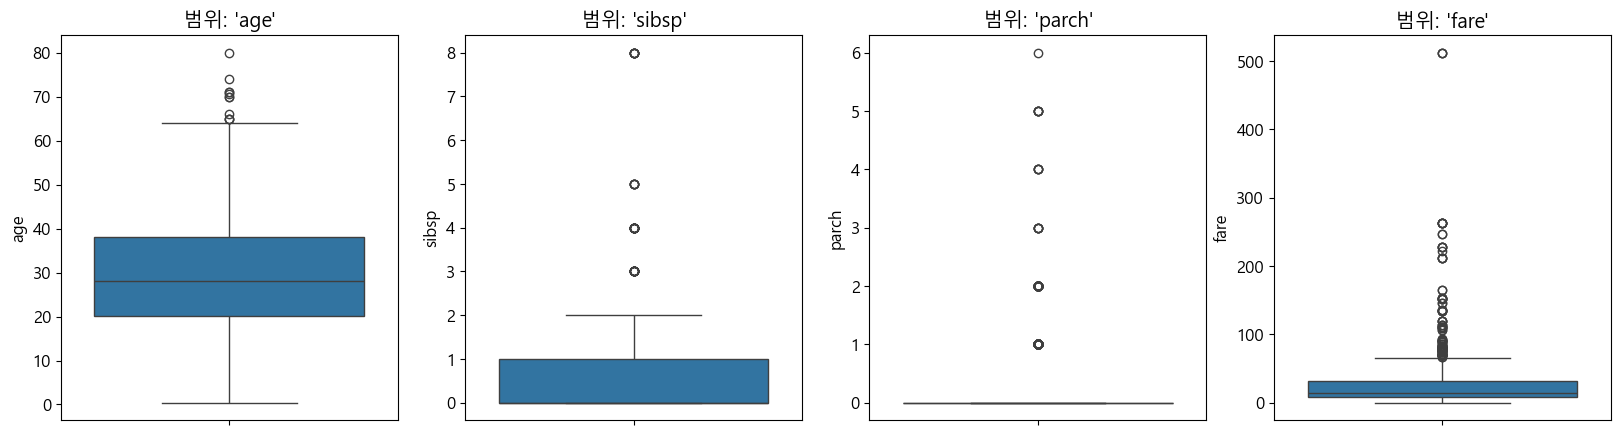

In [79]:
fig, ax_list = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(20,5)
# print(ax_list.shape)

# for i in range(len(ax_list)) : 
#     # print(i)
#     # print(numerical_cols2[i])
#     col = numerical_cols2[i]

for i,col in enumerate(numerical_cols2):
    # print(i,col)
    ax = sns.boxplot(data=titanic_df, y=col,showfliers=True ,ax=ax_list[i])
    ax.set_title(f"범위: '{col}'")

#### [문제해결] sns.histplot()으로, 수치형 데이터의 분포 알아보기

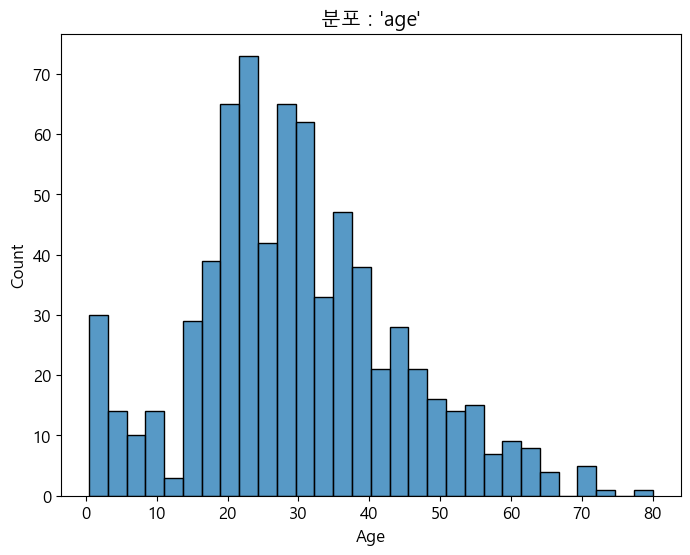

In [106]:
# 'age' 컬럼의 값 빈도수를 시리즈로 계산
age_counts = titanic_df['age'].value_counts().sort_index()

# 시각화를 위한 데이터프레임 만들기
age_df = pd.DataFrame({'age': age_counts.index, 'count': age_counts.values})

# 시각화
plt.figure(figsize=(8, 6))
sns.histplot(data=age_df, x='age', weights='count', bins=30)
plt.title("분포 : 'age'")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


# for i in range(len(ax_list)):
#     col = numerical_cols[i]
#     sns.histplot(data=titanic_df[numerical_cols], y=col, showfliers=True, ax=ax_list[i])
#     ax_list[i].set_title(f"범위 : '{col}'")

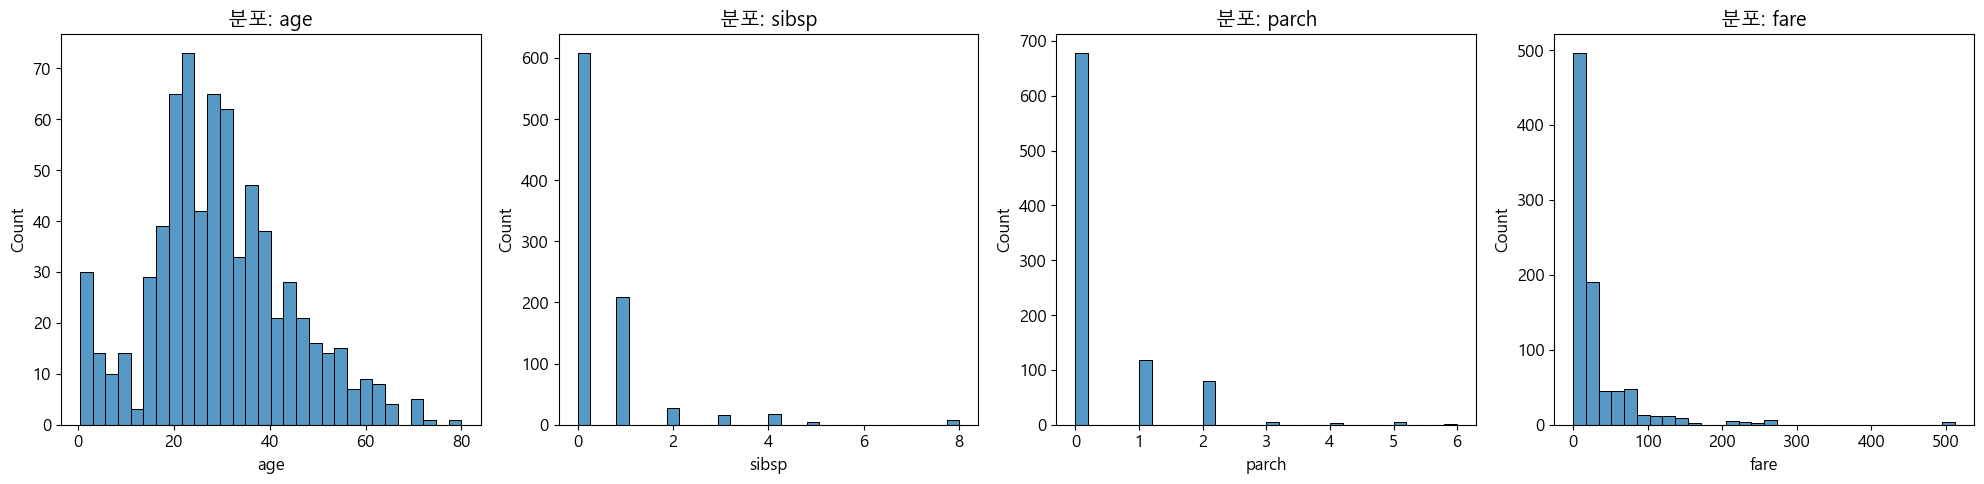

In [117]:
fig, ax_list = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(20, 5)  # 전체 크기 조절

# 확인용
# print(ax_list.shape)

# enumerate로 축(axis)을 함께 가져옵니다.
for i, col in enumerate(numerical_cols2):
    counts = titanic_df[col].value_counts().sort_index()
    df = pd.DataFrame({col: counts.index, 'count': counts.values})
    
    sns.histplot(data=df, x=col, weights='count', bins=30, ax=ax_list[i])
    ax_list[i].set_title(f"분포: {col}")
    ax_list[i].set_xlabel(col)
    ax_list[i].set_ylabel("Count")

plt.tight_layout()
plt.show()



범주형 컬럼들의 분포 그리기. 범주형이므로 countplot을 통해 각 범주별로 개수를 셀 수 있음.

- 범주형 컬럼이 총 8개 이므로, 3x3 canvas 레이아웃으로 하나씩 그래프를 그려봄.
- ax_list는 [[], []] 형태의 2차원 리스트임. for 문으로 반복하기 위해 1차원 리스트로 풀어보기
- 1차원 리스트 ax_list2가 9개의 canvas (ax)를 갖도록 풀어서 할당하는데, .reshape() 라는 numpy함수 사용

(3, 3)
(9,)


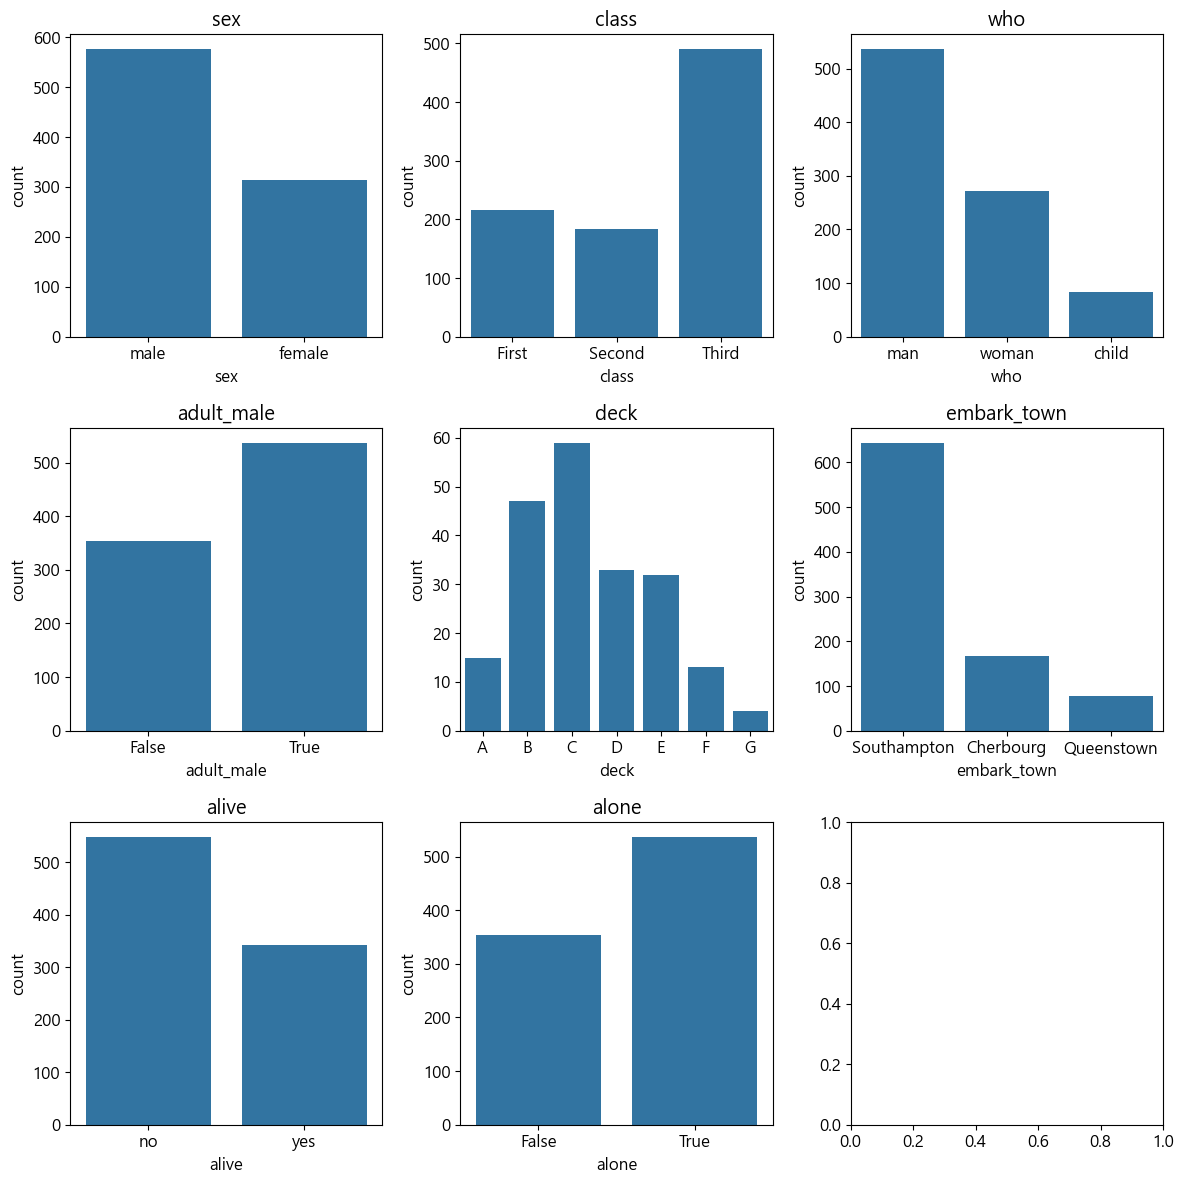

In [102]:
figure, ax_list = plt.subplots(nrows=3, ncols=3);
figure.set_size_inches(12,12)
ax_list2 = ax_list.reshape(3 * 3)  # 다차원 행렬의 차원을 원하는 모양으로 변경합니다.
print(ax_list.shape)
print(ax_list2.shape)

for i in range(len(categorical_cols)):
    col = categorical_cols[i]
    fig = sns.countplot(data=titanic_df, x=col, ax=ax_list2[i])
    fig.set_title(col)
    #fig.set_xticklabels(fig.get_xticklabels(), rotation=45)   # x축 레이블 각도 조절
    
plt.tight_layout()
plt.show()

# 머신러닝을 위한 데이터 전처리 
- 결측 데이터 처리
- 문자형 데이터를 숫자형 데이터로 변환 (레이블 인코딩, 원핫 인코딩)
- 피처스케일링(데이터 수준을 맞춰주는 것)

## 결측 데이터 처리하기 
- 숫자형 데이터, 범주형 데이터를 어떻게 처리할 것인가? 

In [139]:
# deck : 선박에서 배정받은 좌석의 구역
# sibsp : 함께 탑승한 형제, 자매, 배우자 수의 합
# parch : 함께 탑승한 부모, 자식 수의 합
# [문제] 
# sns 내장 데이터 로딩
titanic_df = sns.load_dataset('titanic')
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


### 수치형 데이터의 기술통계 확인 

In [140]:
titanic_df[numerical_cols2].describe()

,age,sibsp,parch,fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


In [141]:
titanic_df[categorical_cols].describe()

,sex,class,who,adult_male,deck,embark_town,alive,alone
count,891,891,891,891,203,889,891,891
unique,2,3,3,2,7,3,2,2
top,male,Third,man,True,C,Southampton,no,True
freq,577,491,537,537,59,644,549,537


결측치 처리 방법 결정 
- age : 평균값으로 채워넣음
- deck : 빈도수가 top인 값으로 넣기
- embarkded : 빈도수가 top 값으로 넣기 

### [문제해결] numerical value : 결측치 평균나이로 채우기

In [147]:
# age 평균으로 채우기 
titanic_df['age']= titanic_df['age'].fillna(titanic_df['age'].describe()['mean'])
titanic_df.info()              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [138]:
# deck 컬럼, embarked 컬럼 최빈값 top으로 채우기
titanic_df['deck']= titanic_df['deck'].fillna(titanic_df['deck'].describe()['top'])
#titanic_df['deck'].fillna(titanic_df['deck'].describe()['top'], inplace=True)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          0 non-null      object  
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         891 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(1), int64(4), object(6)
memory usage: 80.7+ KB


### 중복된 컬럼 제거 

In [148]:
titanic_df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.000000,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.000000,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.000000,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.000000,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.000000,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.000000,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,29.699118,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.000000,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


### [문제해결] drop duplicated columns(중복된 컬럼 삭제)

In [150]:
drop_cols = ["class", "embark_town", "alive"]
# 출복 컬럼 삭제
titanic_df_clean = titanic_df.drop(columns=drop_cols)
titanic_df_clean

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,adult_male,deck,alone
0,0,3,male,22.000000,1,0,7.2500,S,man,True,NaN,False
1,1,1,female,38.000000,1,0,71.2833,C,woman,False,C,False
2,1,3,female,26.000000,0,0,7.9250,S,woman,False,NaN,True
3,1,1,female,35.000000,1,0,53.1000,S,woman,False,C,False
4,0,3,male,35.000000,0,0,8.0500,S,man,True,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S,man,True,NaN,True
887,1,1,female,19.000000,0,0,30.0000,S,woman,False,B,True
888,0,3,female,29.699118,1,2,23.4500,S,woman,False,NaN,False
889,1,1,male,26.000000,0,0,30.0000,C,man,True,C,True


## 레이블 인코딩 ()

### 머신러닝은 숫자형 데이터 만 입력할 수 있는데 문자형은 어떻게 처리해야할까?
- string type을 numerical type으로 변형 => label encoding

In [151]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
titanic_df_clean['sex'] = le.fit(titanic_df_clean['sex']).transform(titanic_df_clean['sex'])
titanic_df_clean['adult_male'] = le.fit(titanic_df_clean['adult_male']).transform(titanic_df_clean['adult_male'])
titanic_df_clean['alone'] = le.fit(titanic_df_clean['alone']).transform(titanic_df_clean['alone'])
titanic_df_clean['embarked'] = le.fit(titanic_df_clean['embarked']).transform(titanic_df_clean['embarked'])
titanic_df_clean['deck'] = le.fit(titanic_df_clean['deck']).transform(titanic_df_clean['deck'])
titanic_df_clean['who'] = le.fit(titanic_df_clean['who']).transform(titanic_df_clean['who'])

In [152]:
titanic_df_clean.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,adult_male,deck,alone
0,0,3,1,22.0,1,0,7.2500,2,1,1,7,0
1,1,1,0,38.0,1,0,71.2833,0,2,0,2,0
2,1,3,0,26.0,0,0,7.9250,2,2,0,7,1
3,1,1,0,35.0,1,0,53.1000,2,2,0,2,0
4,0,3,1,35.0,0,0,8.0500,2,1,1,7,1


In [153]:
# age 컬럼 int type으로 변경
titanic_df_clean['age'] = titanic_df_clean['age'].astype(int)
titanic_df_clean.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,adult_male,deck,alone
0,0,3,1,22,1,0,7.2500,2,1,1,7,0
1,1,1,0,38,1,0,71.2833,0,2,0,2,0
2,1,3,0,26,0,0,7.9250,2,2,0,7,1
3,1,1,0,35,1,0,53.1000,2,2,0,2,0
4,0,3,1,35,0,0,8.0500,2,1,1,7,1


### 피처 셀렉션 
- 상관계수로 관계성 확인 
- 이상치가 심각하게 많거나 결측치가 너무 많은 때는 제거

- titanic_df_clean 데이트 파일로 저장하기

In [154]:
import os
if not os.path.exists('ml_datas'):
    os.mkdir('ml_datas')
titanic_df_clean.to_csv('ml_datas/titanic_df_clean.csv', index=False)    

# 머신러닝 모델 학습 및 평가 

### 학습데이터, 테스트 데이터 준비 
X_train_feature, X_text_feature, y_train_target, y_test_target = train_test_split(feature_data, target_data)

- test_size : train 데이터와 test 데이터 분할 비율, default 0.25
- shuffle : split을 하기전에 섞을 건지 설정, default=True
- stratify : class 비율을 train과 validation을 일정하게 유지함, 한쪽으로 쏠려서 분배되는 것 방지(stratify=target), default=None
- random_state ; 매번 동일한 데이터 셋으로 분할하는 것을 재현하기 위해 동일한 숫자를 설정함. default=None